In [2]:
from IPython.display import Image
import torch
import numpy as np
import pandas as pd
from torch import nn

# Generative Adversarial Nets (GAN)

У VAE есть существенная проблема. Она на самом деле сильно теряет информацию. С этим можно каким-то образом бороться, но факт того, что мы не сможем восстановить мелкие детали изображений - очевиден. 
Мы можем сохранить только некоторое напрвление *движения* картинки.

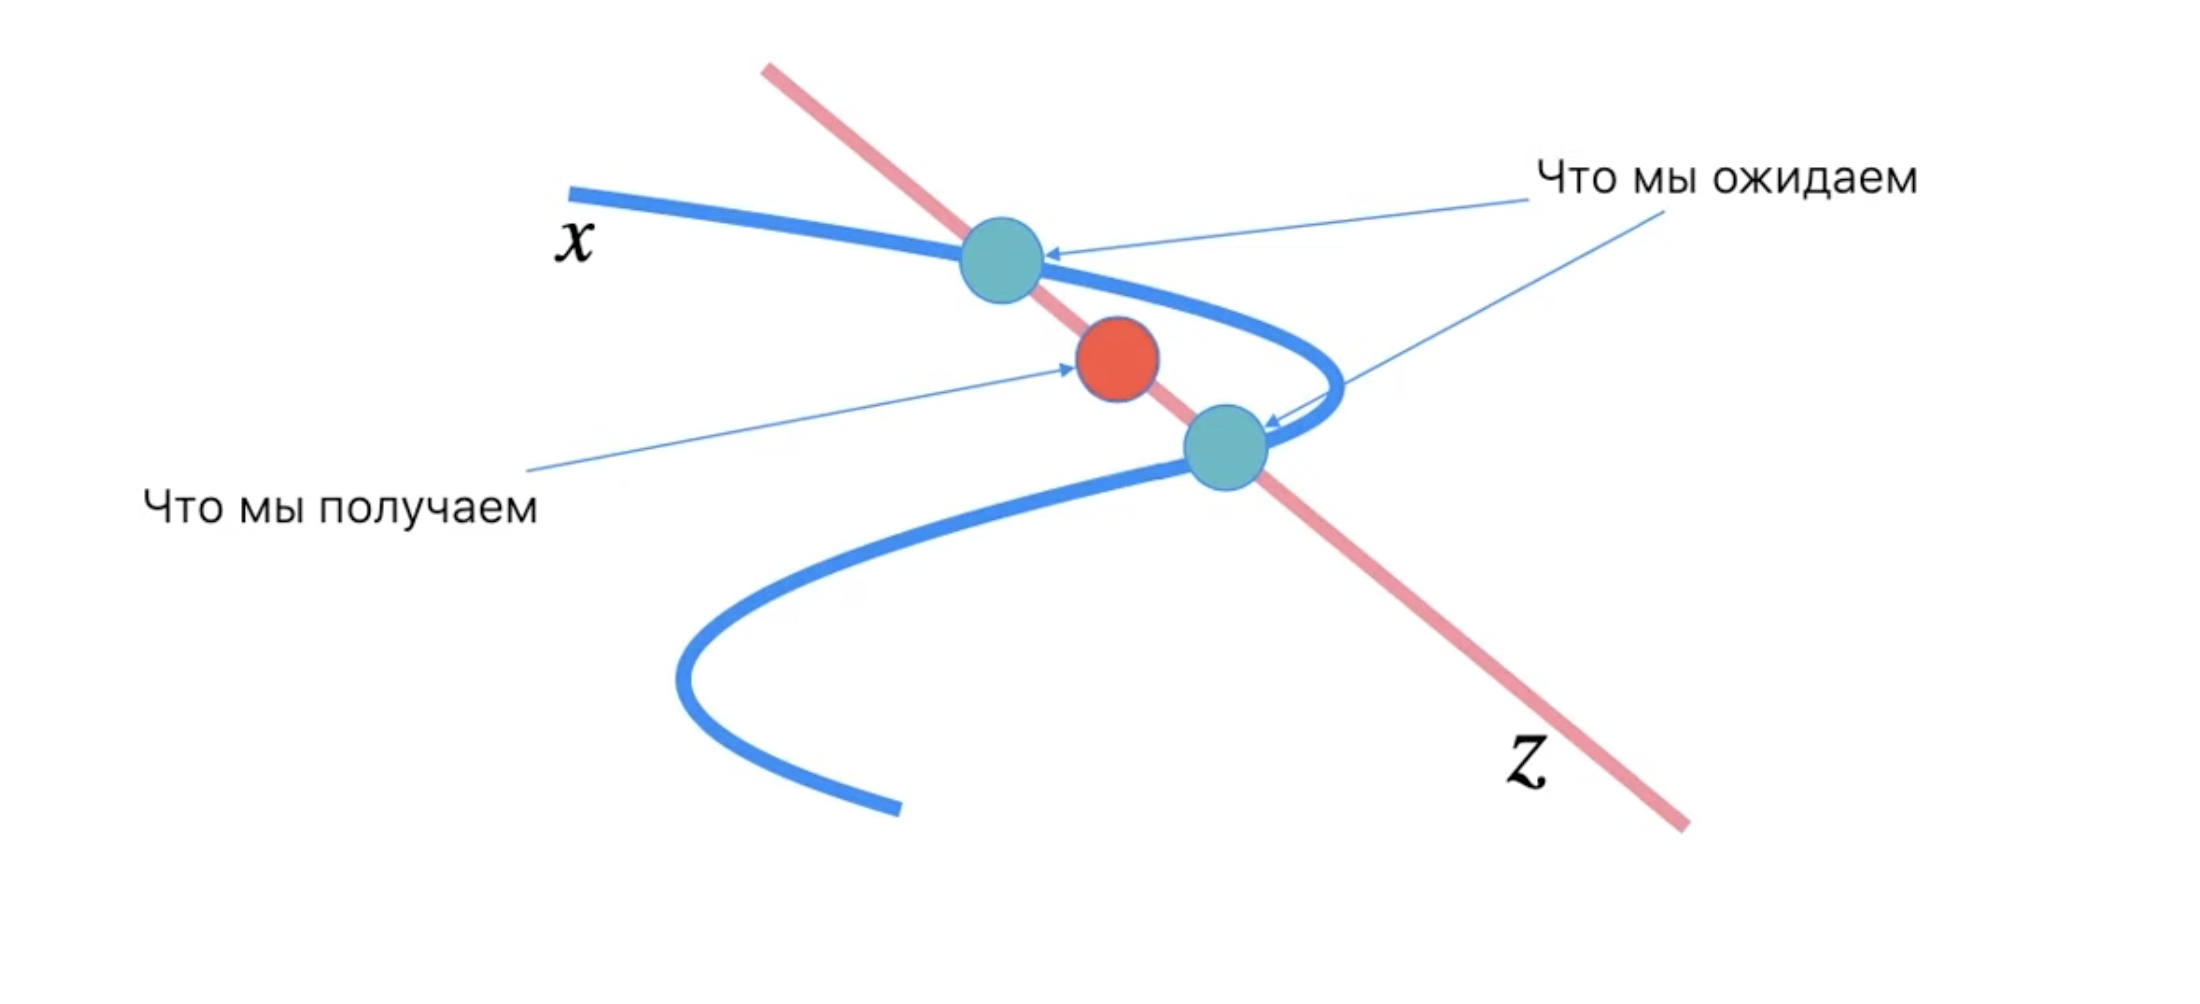

In [12]:
Image('images/gan45.png', width=600)

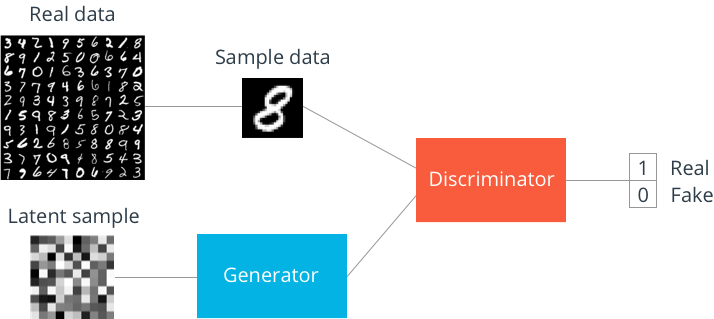

In [10]:
Image('images/gan4.png', width=600)

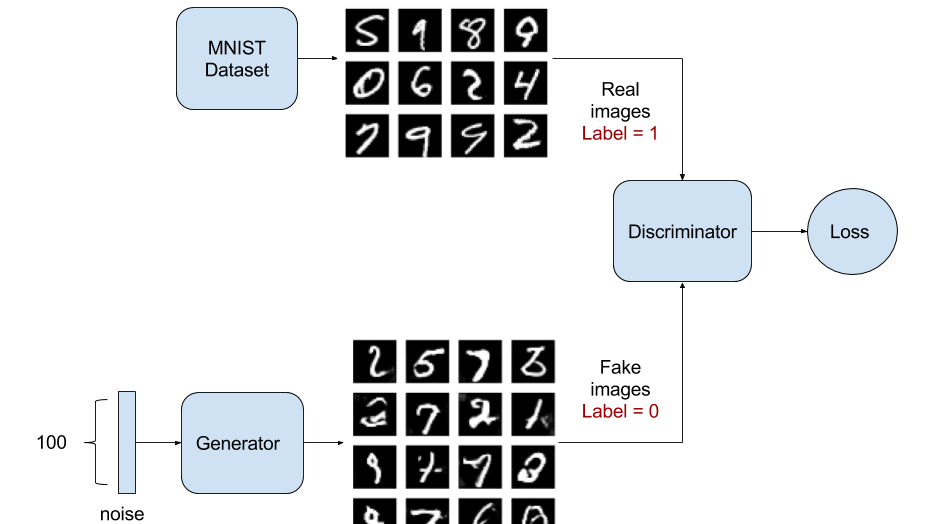

In [11]:
Image('images/gan5.png', width=600)

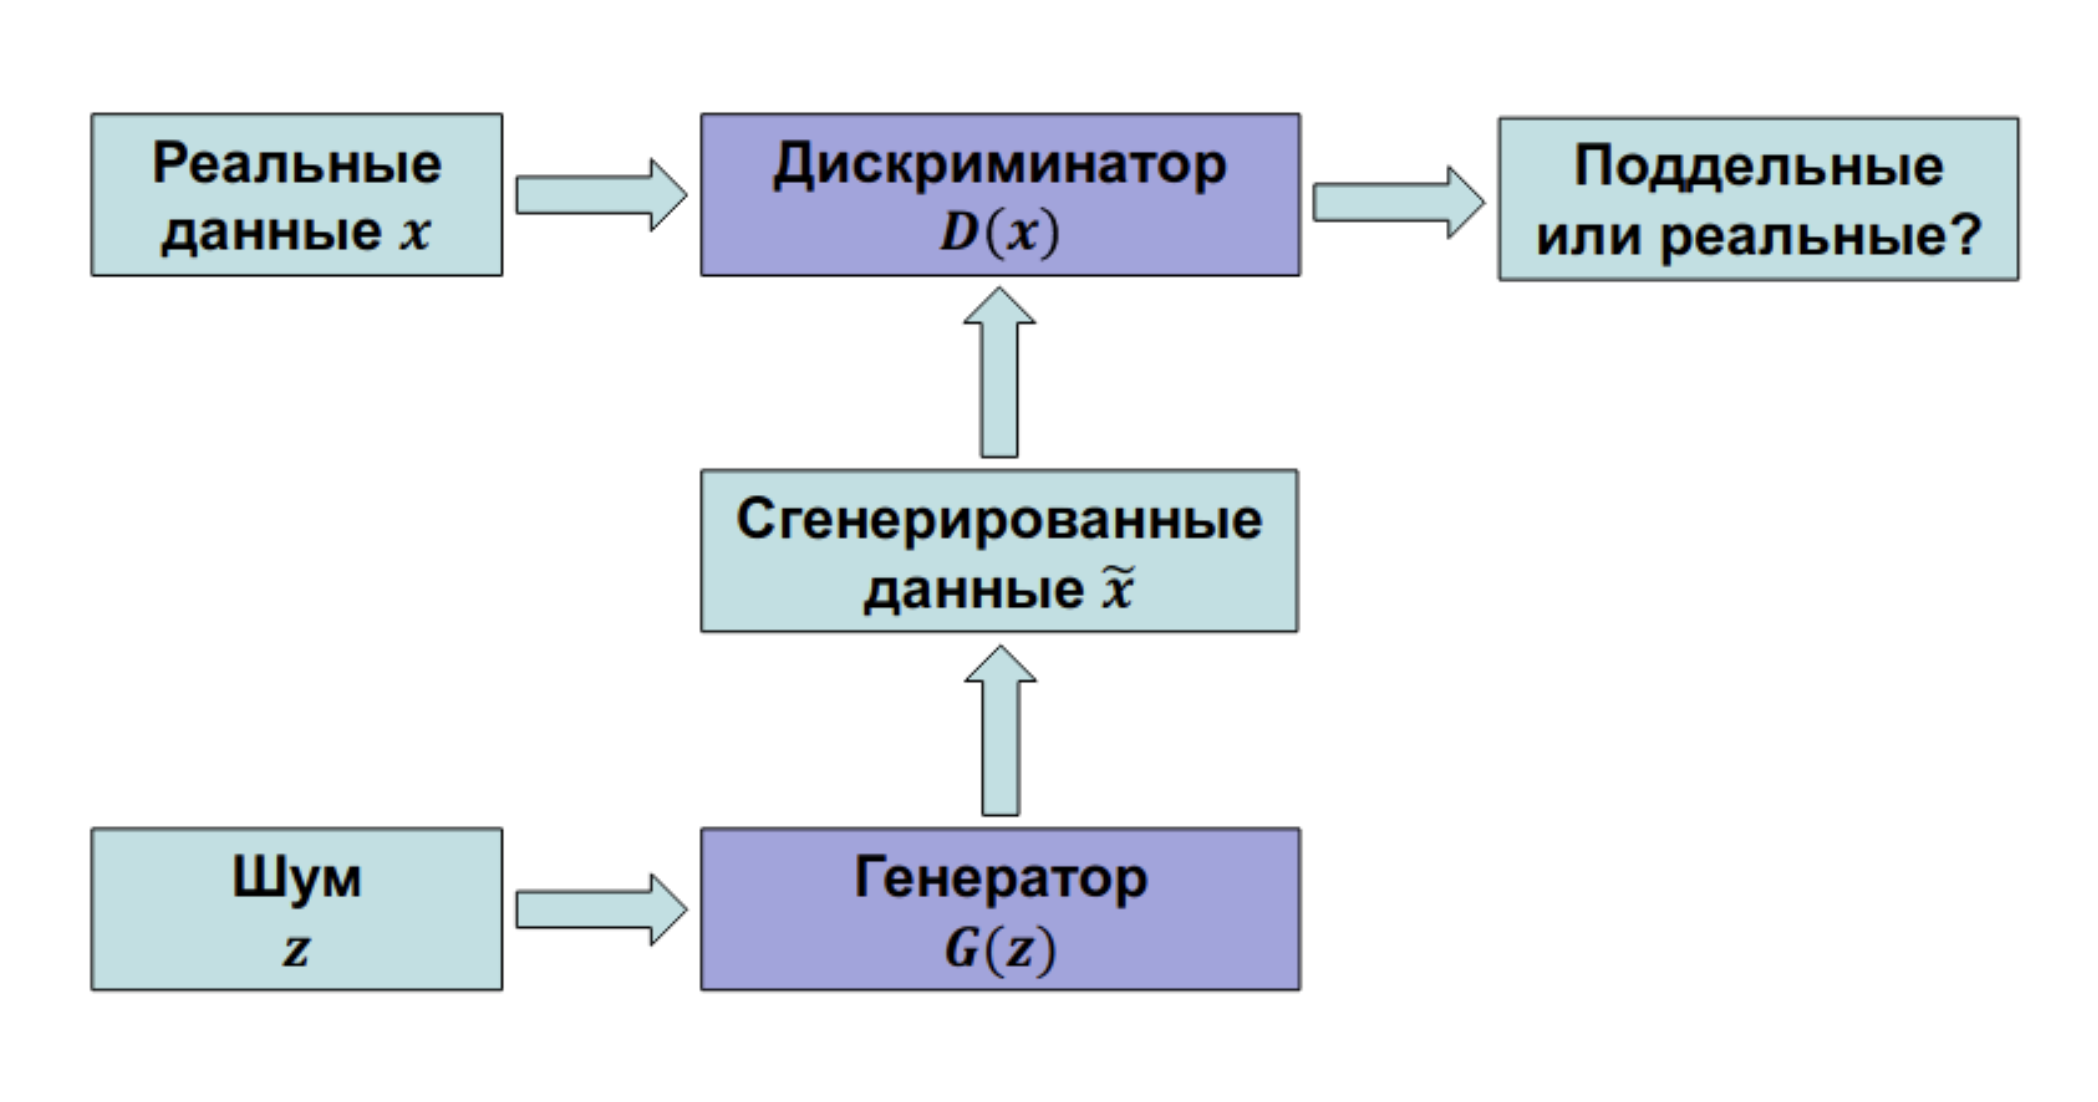

In [9]:
Image('images/gan1.png', width=600)

Опишем генеративно-состязательную сеть неформально. Она состоит из двух нейронных сетей:    

- **Генератор** $-$ сеть, которая генерирует образцы. Цель генератора - научиться обманывать дискриминатор.

- **Дискриминатор (классификатор)** $-$ сеть, которая пытается отличить реальные наблюдения от сгенерированных образцов. Цель дискриминатора $-$ научиться наилучшим образом отличать обман.

$X\ -$ множество наблюдений из распределений $p_{data}$.

$Z\ -$ пространство скрытых векторов из распределения $p_z$. $Z = ℝ^n$

### Генератор

- $G: Z \to ℝ^n\ -$ функция-генератор с параметрами $\theta$

- Цель $G\ -$ сгенерировать образец, максимально похожий на наблюдения из распределения $p_{data}$

### Дискриминатор (классификатор)

- $D: X \to (0, 1)\ -$ функция-дискриминатор с параметрами $\gamma$ 

- Цель $D\ -$ выдавать максимальную оценку на наблюдениях из $X$ и минимальную оценку на образцах, сгенерированных $G$

$\theta$ и $W$ $-$ параметры нейронных сетей, соответствующих генератору и дискриминатору

В качестве функции ошибки возьмём следующую функцию:    

$loss = E_{x}[log D(x)] +  E_{z}[log(1 - D(G(z))]$

## Алгоритм обучения GAN

### Этап 1

На этом этапе у нас параметры генератора $\theta$ зафиксированы.

1. Сэмплировать $\{x_1, x_2, ..., x_m\}$ из распределения $p_{data}$

2. Сэмплировать $\{z_1, z_2, ..., z_m\}$ из распределения $p_z$

3. Обновить параметры дискриминатора $\gamma$ (метод обратного распространения ошибки)

  $\Delta W 	\leftarrow \nabla_{W}\frac{1}{B}\sum\limits_{t=1}\limits^B log\ D(x_t) + log\ (1 - D(G(z_t)))$

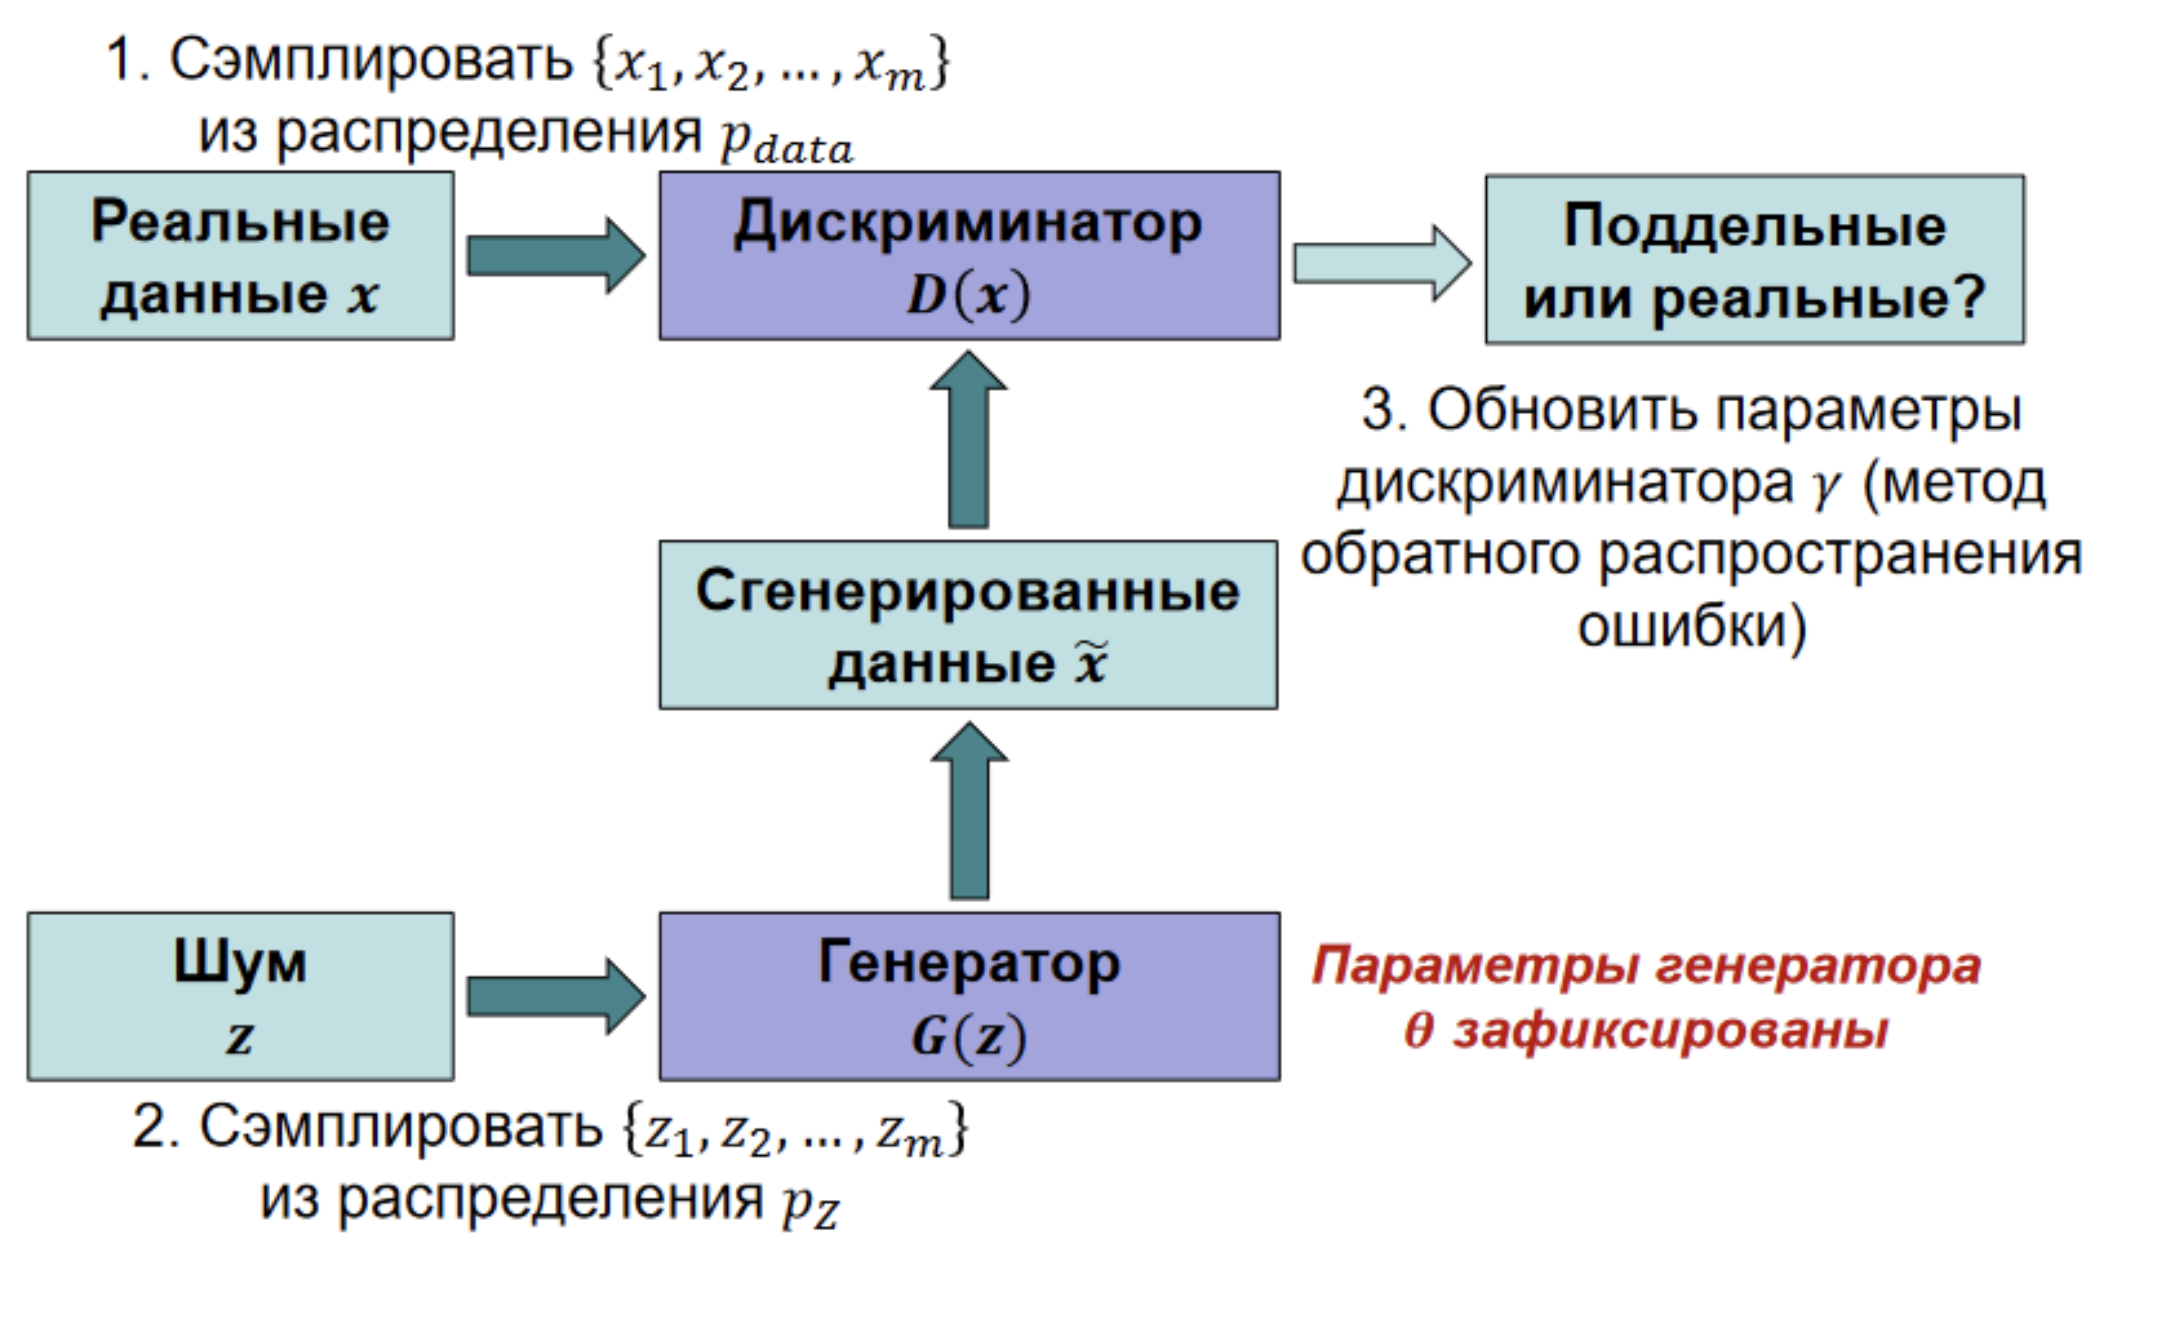

In [7]:
Image('images/gan2.png', width=600)

### Этап 2

На этом этапе у нас параметры дискриминатора $\gamma$ зафиксированы.

1. Сэмплировать $\{z_1, z_2, ..., z_m\}$ из распределения $p_z$

2. Обновить параметры генератора $\theta$ (метод обратного распространения ошибки)

  $\Delta \theta 	\leftarrow \nabla_{\theta}\frac{1}{m}\sum\limits_{t=1}\limits^m log\ (1 - D(G(z_t)))$

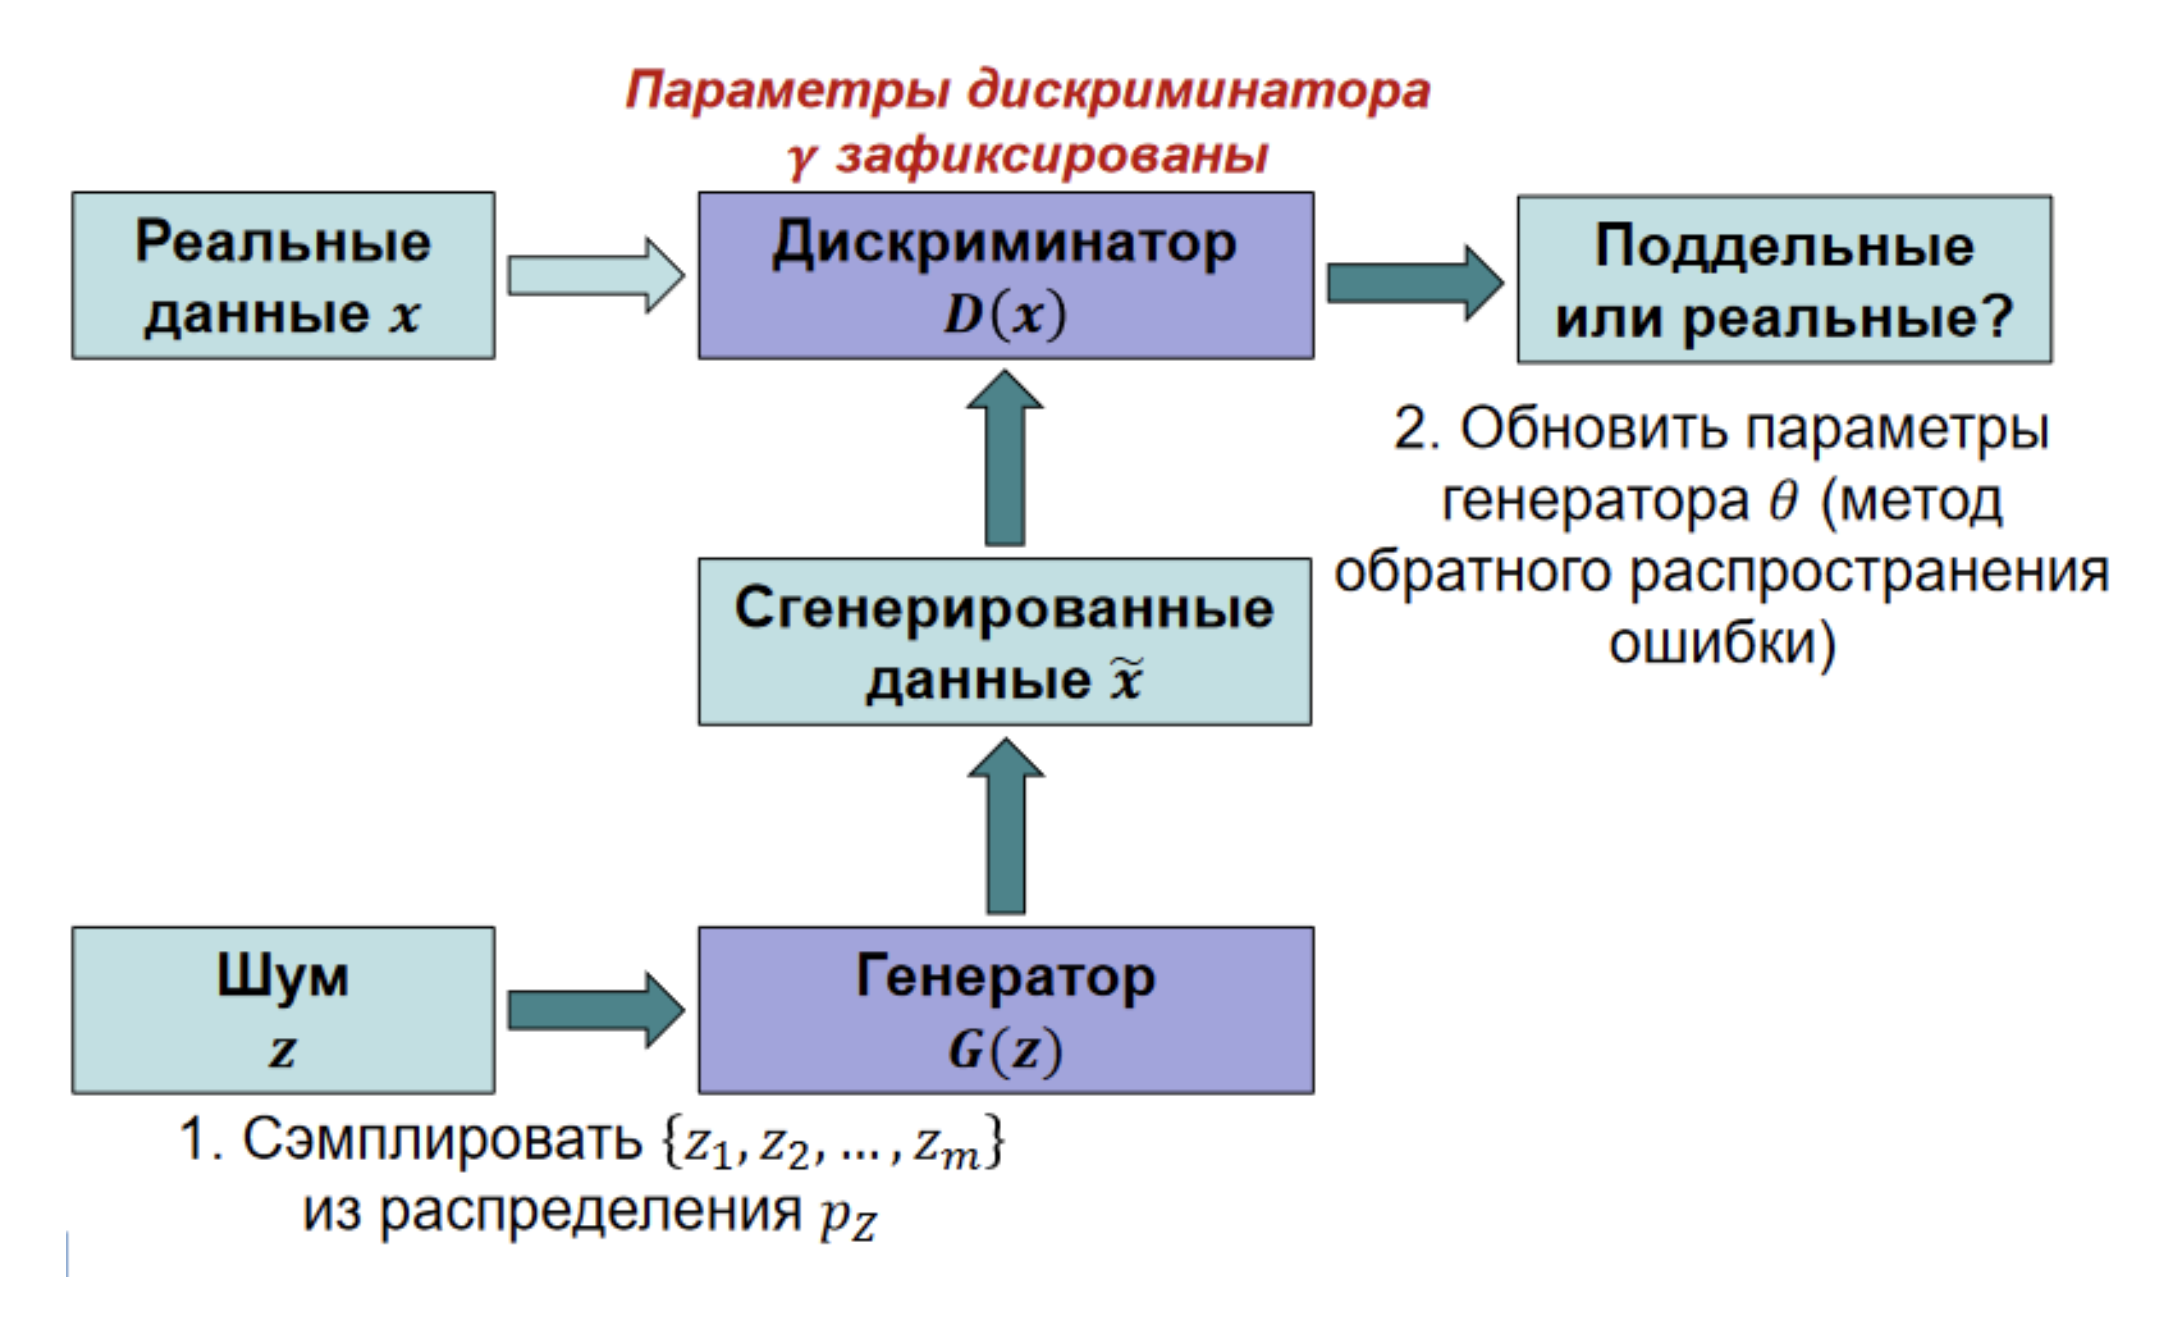

In [8]:
Image('images/gan3.png', width=600)

В этом ноутбуке мы попробуем обучить GAN генерировать морды кошек из случайного шума. Датасет с кошками взят отсюда:
https://www.kaggle.com/spandan2/cats-faces-64x64-for-generative-models

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ml2021/cats.zip

In [5]:
DATA_DIR = './cats/'

In [6]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

Подготовим наши изображения к дальнейшему использованию

In [7]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [8]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [10]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Посмотрим, как выглядит батч

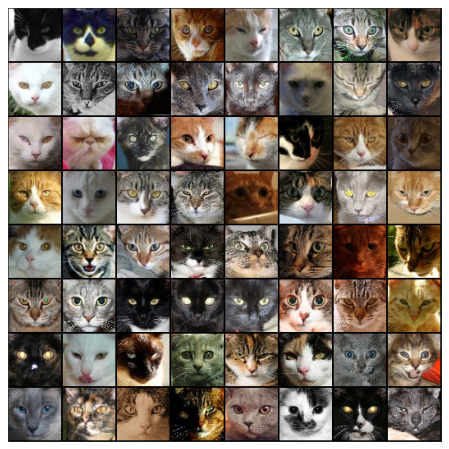

In [11]:
show_batch(train_dl)

In [12]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

Давайте перейдем непосредственно к построению GANа. Напомним, что GAN состоит из двух сетей: *генератора*, задача которого – научиться генерировать изображения, похожие на обучающую выборку, из случайного шума, и *дискриминатора*, который учится распознавать, настоящее это изображение или сгенерированное генератором.

Построим генератор и дискриминатор на свертках:

In [15]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [16]:
discriminator = to_device(discriminator, device)

In [17]:
latent_size = 128

In [18]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Посмотрим, как выглядит шум, из которого будут генерироваться изображения

torch.Size([128, 3, 64, 64])


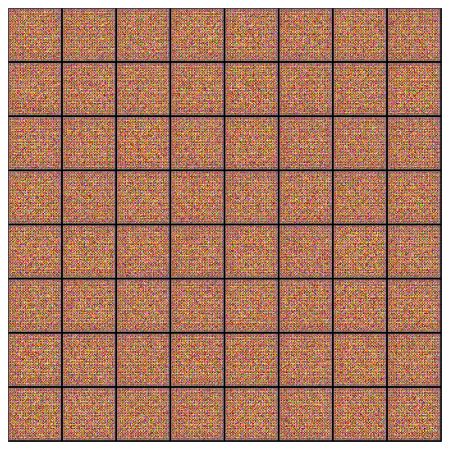

In [19]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [20]:
generator = to_device(generator, device)

In [21]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [22]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [24]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device) #присваиваем 1 реальным изображениям
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent) #связка с генератором

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images) #связка с дискриминатором
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [25]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 40

In [26]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 7.6997, loss_d: 0.4812, real_score: 0.8554, fake_score: 0.1471


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 3.9614, loss_d: 0.6094, real_score: 0.7938, fake_score: 0.1997


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 3.6442, loss_d: 0.6866, real_score: 0.7653, fake_score: 0.2290


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 3.7047, loss_d: 0.6898, real_score: 0.7659, fake_score: 0.2417


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 4.0351, loss_d: 0.7455, real_score: 0.7581, fake_score: 0.2410


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 4.4279, loss_d: 0.7529, real_score: 0.7688, fake_score: 0.2244


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 4.3691, loss_d: 0.7593, real_score: 0.7608, fake_score: 0.2414


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 4.5420, loss_d: 0.7220, real_score: 0.7828, fake_score: 0.2196


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 4.3517, loss_d: 0.7024, real_score: 0.7865, fake_score: 0.2154


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 4.2845, loss_d: 0.7398, real_score: 0.7904, fake_score: 0.2079


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 4.1510, loss_d: 0.6752, real_score: 0.7969, fake_score: 0.2067


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 4.1193, loss_d: 0.6179, real_score: 0.7999, fake_score: 0.1938


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 4.3256, loss_d: 0.6539, real_score: 0.8004, fake_score: 0.1990


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 4.3585, loss_d: 0.5996, real_score: 0.8123, fake_score: 0.1855


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 4.2632, loss_d: 0.6071, real_score: 0.8182, fake_score: 0.1834


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 4.2262, loss_d: 0.5703, real_score: 0.8227, fake_score: 0.1796


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 4.6506, loss_d: 0.5167, real_score: 0.8303, fake_score: 0.1712


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 4.5991, loss_d: 0.5459, real_score: 0.8318, fake_score: 0.1697


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 4.5295, loss_d: 0.4477, real_score: 0.8509, fake_score: 0.1440


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 4.6982, loss_d: 0.5084, real_score: 0.8444, fake_score: 0.1561


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 4.7853, loss_d: 0.4215, real_score: 0.8596, fake_score: 0.1368


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 4.9194, loss_d: 0.4593, real_score: 0.8558, fake_score: 0.1449


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 5.1612, loss_d: 0.3676, real_score: 0.8772, fake_score: 0.1270


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 5.0468, loss_d: 0.4069, real_score: 0.8731, fake_score: 0.1255


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 5.1983, loss_d: 0.3255, real_score: 0.8934, fake_score: 0.1039


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 5.1029, loss_d: 0.3236, real_score: 0.8909, fake_score: 0.1097


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 5.2237, loss_d: 0.3091, real_score: 0.8967, fake_score: 0.1052


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 5.2839, loss_d: 0.3557, real_score: 0.8832, fake_score: 0.1138


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 5.2579, loss_d: 0.3353, real_score: 0.8908, fake_score: 0.1092


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 5.4701, loss_d: 0.3125, real_score: 0.9016, fake_score: 0.1050


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 5.3853, loss_d: 0.2642, real_score: 0.9076, fake_score: 0.0887


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 5.3471, loss_d: 0.2649, real_score: 0.9114, fake_score: 0.0889


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 5.6360, loss_d: 0.2912, real_score: 0.9109, fake_score: 0.0868


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 5.3649, loss_d: 0.1928, real_score: 0.9301, fake_score: 0.0723


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 5.7550, loss_d: 0.2752, real_score: 0.9143, fake_score: 0.0833


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 5.8565, loss_d: 0.2317, real_score: 0.9231, fake_score: 0.0743


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 5.6281, loss_d: 0.2653, real_score: 0.9186, fake_score: 0.0851


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 5.8599, loss_d: 0.1619, real_score: 0.9402, fake_score: 0.0619


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 6.1927, loss_d: 0.3284, real_score: 0.9034, fake_score: 0.0941


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 5.7836, loss_d: 0.1442, real_score: 0.9438, fake_score: 0.0584
Saving generated-images-0040.png


Посмотрим на результаты обучения. Вот так выглядят котики, сгенерированные на последней эпохе обучения:

In [27]:
losses_g, losses_d, real_scores, fake_scores = history

In [28]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

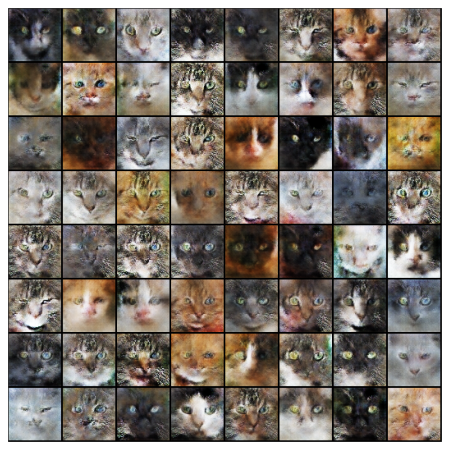

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Как мы видим, изображение в целом получается похожим, однако есть много артефактов

Посмотрим на графики loss генератора и дискриминатора и score дискриминатора

torch.Size([128, 3, 64, 64])


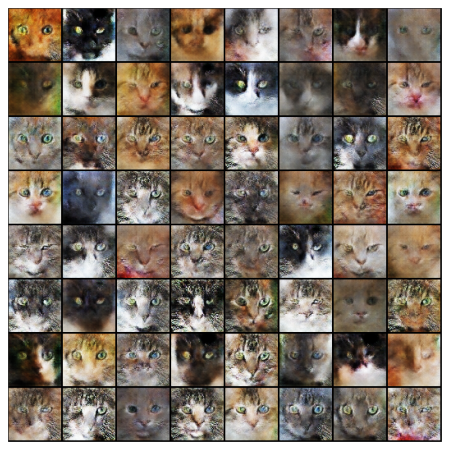

In [35]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb.to(device))
print(fake_images.shape)
show_images(fake_images.cpu())

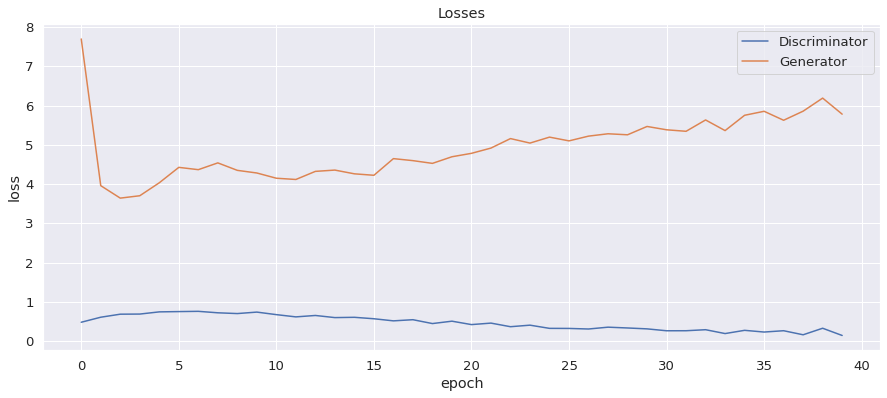

In [30]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

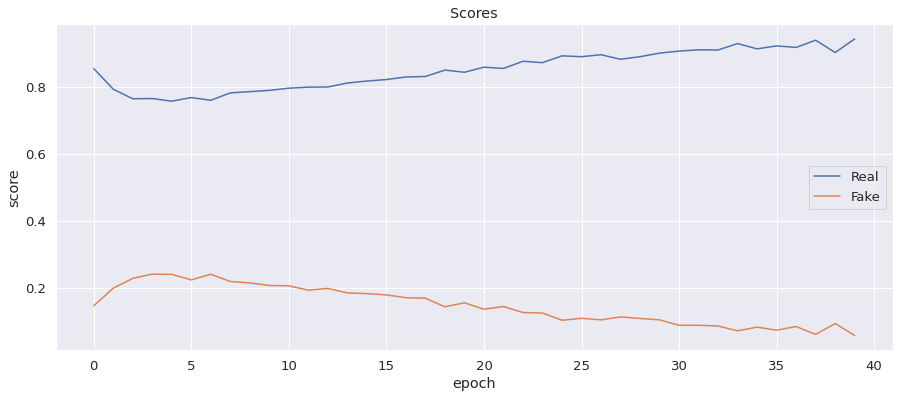

In [31]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Поведение графиков примерно такое же, как было показано на лекции

# Ссылки

1. https://habr.com/ru/company/otus/blog/569858/

2. https://habr.com/ru/post/352794/

3. http://hpc-education.unn.ru/files/courses/intel-dl-cv-course/Rus/Lectures/Presentations/07_GANs_SyntheticData_Rus_pptx.pdf

4. https://arxiv.org/pdf/1406.2661.pdf